"""
Created on Wed Jun 19 17:45:50 2019

@author:gusmaogabriels@gmail.com // gusmaogabriels@gatech.edu

"""

## Forward and Inverse ANN ODE

Using JAX to 

   1. Reproduce the **forward-problem** results from [**Solving coupled ODEs with a neural network and autograd**](http://kitchingroup.cheme.cmu.edu/blog/category/ode/ ) (Kitchin's Group)

   * Show that the **inverse-problem** can be solved given data.
   * Demonstrate that the **inverse-problem** can be solved given **noisy** data.
   * Run a **proof of concept** for solving for the **inverse problem with latent variables** (features).

-*- coding: utf-8 -*-

#### Necessary Libraries

In [1]:
from __future__ import print_function, division, absolute_import
import jax.numpy as np
from numpy.random import choice
from jax import grad, jit, vmap, jacobian, jacfwd, jacrev
from jax import random
from jax.scipy.special import logsumexp
from jax.experimental import optimizers
from jax.config import config
from jax.tree_util import tree_map
config.update("jax_debug_nans", True)
config.update('jax_enable_x64', True)
import time
from IPython.display import clear_output
from matplotlib import pyplot as plt
import itertools

#### Set of helper functions based on [JAX tutorials](https://colab.research.google.com/github/google/jax/blob/master/notebooks/neural_network_with_tfds_data.ipynb) ***(Google Colabs)***

*Dense Neural Network: random initialization of layers weights and biases.*

In [2]:
# A helper function to randomly initialize weights and biases
# for a dense neural network layer
def random_layer_params(m, n, key, scale=1e-2):
    w_key, b_key = random.split(key)
    return scale * random.normal(w_key, (n, m)), scale * random.normal(b_key, (n,))

*Own modification of random_layer_params to generate model parameters.*

In [3]:
# A helper function to randomly initialize weights and biases
# for a dense neural network layer
def random_model_params(m, key, scale=1e-2):
    #w_key, b_key = random.split(key)
    #print(tuple(scale * random.normal(key, (m, 1))))
    return (scale * random.normal(key, (m,)))#, scale * random.normal(b_key, (n,))

Network and model initialization functions

In [4]:
# Initialize all layers for a fully-connected neural network with sizes "sizes"
def init_network_params(sizes, key, scale):
    keys = random.split(key, len(sizes))
    return [random_layer_params(m, n, k, scale) for m, n, k in zip(sizes[:-1], sizes[1:], keys)]

In [5]:
def init_model_params(size, key, scale):
 key = random.split(key,2)[-1] 
 return [random_model_params(s, key, scale) for s in size]

Universal activation function to be used. (JIT precompiled)

In [6]:
@jit
def act_fun(x):
    #return np.maximum(0, x)
    #return np.nan_to_num(x / (1.0 + np.exp(-x)))
    #return x / (1.0 + np.exp(-x))
    return 2./(1.+np.exp(-2.*x))-1.
    #return 0.5*np.tanh(x) + 0.5*x / (1.0 + np.exp(-x))
    #return(x)

ANN evaluator for *state* variables. (JIT precompiled)

In [7]:
@jit
def state(params, t):
    # per-example stateions
    activations = t
    for w, b in params[:-1]:
        outputs = np.dot(w, activations) + b
        activations = act_fun(outputs)
    
    final_w, final_b = params[-1]
    y = (np.dot(final_w, activations) + final_b)
    #y = y / y.sum()
    return y

# Make a batched version of the `state` function
batched_state = vmap(state, in_axes=(None,0))#, in_axes=(None, 0))

Derivatives of state variables with respect to inputs using autograd `jacfwd` for tall Jacobians. (JIT precompiled)

In [8]:
@jit
def diff_state(params,t):
        i = np.arange(len(t))
        #return (jacobian(batched_state,argnums=1)(params,t)[i,:,i,0])
        return np.nan_to_num(jacfwd(lambda t : batched_state(params,t))(t)[i,:,i,0])

### Kinetic Model Definitions

as in [**Solving coupled ODEs with a neural network and autograd**](http://kitchingroup.cheme.cmu.edu/blog/category/ode/ ) (Kitchin's Group)

Model parameters (rate constants): `model_params0`  
Boundary conditions (concentrations at $t=0$): `bc0`

In [9]:
model_params0 = [np.array([1.,1.])]
bc0=np.array([1.0,0.0,0.0])

/home/ggusmao3/.pyenv/versions/ML/lib/python3.6/site-packages/jax/lib/xla_bridge.py:130: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


Model function, `x` are state variables, `t` the independet variable (e.g. time) and `model_params` packs all potential model parameters to be parsed to the function. The latter is important if they are actually changed in a different setup, e.g. solving the inverse problem, which will be shown in the next tutorial.

In [10]:
@jit
def model(batch, model_params):
    #print('model x: {}'.format(x))
    #print('model params: {}'.format(model_params))
    x, t = batch
    k,  = model_params
    return np.array([[-k[0]*x[0]],
                    [k[0]*x[0]-k[1]*x[1]],
                    [k[1]*x[1]]])

batched_model = lambda batch, model_params : vmap(model,in_axes=(0,None))(batch,model_params)[:,:,0]#, in_axes=(None, 0)

### Forward-problem numerical solution

The following numerical solution using `scipy.integrate`'s `solve_ivp` initial-value-problem solver will be used as benchmark for the NN-based equivalent solution.

In [11]:
%%time

from scipy.integrate import solve_ivp

def ode(t,C):
    return model([C,t], model_params0).flatten()

tmax = 10. # max time to evaluate
n_points = int(10*tmax) # number of points

#t_eval = np.logspace(0,np.log10(tmax),n_points)-1.
t_eval = np.linspace(0,tmax,n_points)
sol = solve_ivp(ode, (0, tmax), bc0, t_eval = t_eval)

CPU times: user 52.4 ms, sys: 8.55 ms, total: 61 ms
Wall time: 74.6 ms


#### Numerical Results

Text(0.5, 1.0, 'ODE Numerical Solution')

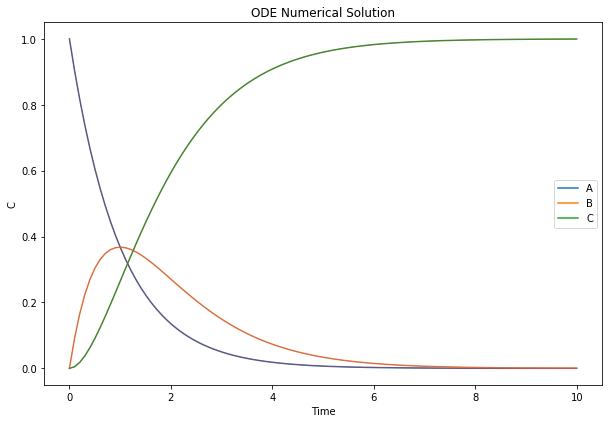

In [12]:
plt.figure(figsize=[10,10*2./3])
t = sol.t
x0 = sol.y.T
x = x0
lines = plt.plot(sol.t, x0)
plt.plot(sol.t, x,'-',ms=5,lw=0.5)
plt.xlabel('Time')
plt.ylabel('C');
plt.legend(iter(lines), ['A', 'B', 'C'])
plt.title('ODE Numerical Solution')

## 1. Neural Net (NN) ODE ***forward*** solution

*Own development.*

Pack `t` as the generic `data` holder for the NN training.

In [13]:
t = t.reshape(-1,1)
data_fwd = t

#### Forward problem error function

Returns:

   `err_model`: sum of square-errors between NN derivatives with respect to inputs and those coming from the source model.   
   `err_bc`: boundary conditions.

In [14]:
def errors_fwd(params,batch):
    nn_params = params[0]
    t = batch
    pred_x = batched_state(nn_params,t)
    err_model = (diff_state(nn_params,t)-batched_model([pred_x,t.reshape(-1,1)],model_params0))**2 
    err_bc = 100*(batched_state(nn_params,np.array(0).reshape(-1,1))-bc0)**2
    return [err_model, err_bc]

#### Generic loss function

Returns the sum of individual errors from `get_errors`.

In [15]:
def loss(get_errors, params, batch):
    return np.array([_.sum() for _ in get_errors(params,batch)]).sum()

#### Forward NN intialization parameters

In [16]:
layer_sizes = [1, 20, 3] # inputs, hidden..., output layes
nn_scale = 0.01 # weights scales
key = random.PRNGKey(0)
nn_params = init_network_params(layer_sizes, key, nn_scale) # initialize parameters

#### Forward training settings

In [18]:
num_epochs = 100
num_iter = 100
batch_size = n_points
model_params = model_params0

#### Generic training loop function

In [19]:
def train(params,data,ferrors,loss,num_epochs,num_iter,batch_size=None): 
    opt_init, opt_update, get_params = optimizers.adam(1e-3, b1=0.9, b2=0.9999, eps=1e-100)
    
    # Update function (JIT precompiled)
    @jit
    def step(i, opt_state, batch):
        params = get_params(opt_state)
        grads = grad(loss,argnums=1)(ferrors, params, batch)  
        return opt_update(i, grads, opt_state)
    
    itercount = itertools.count()        
    opt_state = opt_init(params)
    if not batch_size:
        batch_size = len(data)

    for j in range(num_epochs):
        sel = random.shuffle(random.PRNGKey(j),np.arange(len(data))) # random shuffle
        batch = data[:batch_size]
        for i in range(int(num_iter)):
            opt_state = step(next(itercount), opt_state , batch) 
        params = get_params(opt_state) 
        loss_it_sample = loss(ferrors, params, batch)    
        loss_it_batch = loss(ferrors, params, data)
        err_model, _ = [_.sum() for _ in ferrors(params,data)]
        print('Epoch: {:4d}, Loss Batch: {:.5e}, Loss Data: {:.5e}, Fit Model: {:.5e}'.format(j,loss_it_sample,loss_it_batch,err_model))
        clear_output(wait=True)
    
    return params

#### Forward problem training loop call

In [20]:
%%time
nn_params = train([nn_params],data_fwd,errors_fwd,loss,num_epochs=100,num_iter=100,batch_size=None)[0]

CPU times: user 35.5 s, sys: 1.14 s, total: 36.6 s
Wall time: 25.8 s


### Forward ANN ODE results

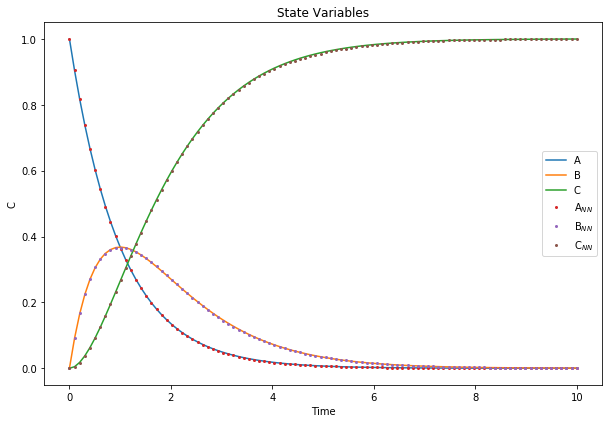

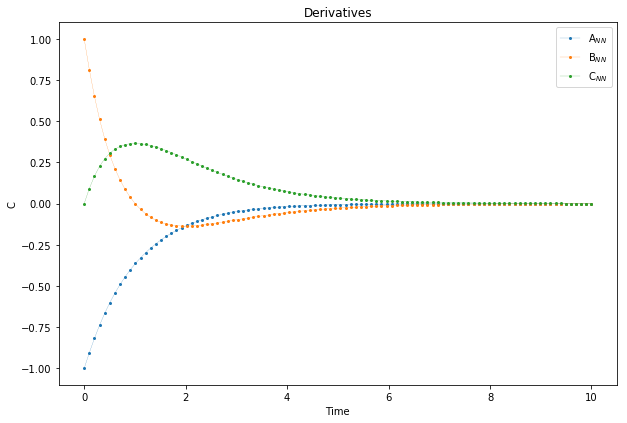

In [21]:
plt.figure(figsize=[10,10*2./3])
lines = plt.plot(sol.t, x0)
lines += plt.plot(t,batched_state(nn_params, t),'o',lw=0.2,ms=2)
plt.legend(iter(lines), ['A', 'B', 'C','A$_{NN}$','B$_{NN}$','C$_{NN}$'])
plt.title('State Variables')
plt.xlabel('Time')
plt.ylabel('C');
plt.figure(figsize=[10,10*2./3])
plt.plot(t,batched_model([batched_state(nn_params,t),t],model_params0),'-o',lw=0.2,ms=2)
plt.legend(['A$_{NN}$','B$_{NN}$','C$_{NN}$'])
plt.title('Derivatives')
plt.xlabel('Time')
plt.ylabel('C');

## 2. Neural Net (NN) ODE *inverse* solution

*Own development.*

Let's change the error function to be in terms of fitting to data, `err_data` and fitting to model, `err_model`. Boundary conditions are not necessary, since we will be fittin the whole problem based on generated data and unkown parameters.

In [22]:
def errors_inv(params,batch):
    x, t = batch
    nn_params, model_params = params
    pred_x = batched_state(nn_params,t)
    err_data = ((pred_x-x)**2).sum(axis=1)
    err_model = ((diff_state(nn_params,t)-batched_model([pred_x,t],model_params))**2 ).sum(axis=1)
    return [err_data, err_model]

`data` is a list of time and data generated above in the numerical solution for the forward problem.

In [23]:
help(random.normal)

Help on function normal in module jax.random:

normal(key, shape=(), dtype=<class 'numpy.float64'>)
    Sample standard normal random values with given shape and float dtype.
    
    Args:
      key: a PRNGKey used as the random key.
      shape: a tuple of nonnegative integers representing the shape.
      dtype: optional, a float dtype for the returned values (default float64 if
        jax_enable_x64 is true, otherwise float32).
    
    Returns:
      A random array with the specified shape and dtype.



In [24]:
data_inv = (x,t)

#### Inverse NN intialization parameters
The neural net weights and model parameters are packed in a single list to be parsed as generic training weights for the `adam` optimizer.

In [25]:
layer_sizes = [1, 20, 3] # inputs, hidden..., output layes
model_size = [len(model_params0[0])]

nn_scale = 0.01 # weights scales
model_scale = 0.0001 # model scale (assume low so as not to eb bias)
key = random.PRNGKey(0)

nn_params = init_network_params(layer_sizes, key, nn_scale)
model_params = init_model_params(model_size, key, model_scale)
params = [nn_params, model_params] #pack

#### Inverse training settings

In [26]:
num_epochs = 100
num_iter = 100
batch_size = n_points

#### Inverse problem training loop call

In [27]:
%%time
params = train(params,data_inv,errors_inv,loss,num_epochs,num_iter,batch_size=None)
[nn_params_inv, model_params_inv] = params

CPU times: user 37.7 s, sys: 1.23 s, total: 39 s
Wall time: 27.2 s


### Inverse ANN ODE results

True parameters: ['1.00000', '1.00000']
Regressed parameters: ['0.96795', '0.98506']


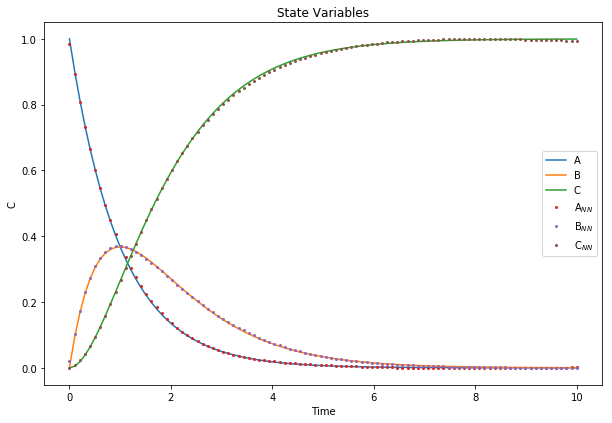

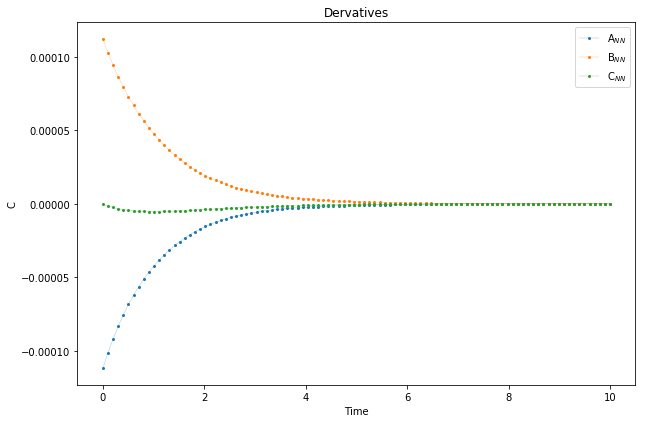

In [28]:
plt.figure(figsize=[10,10*2./3])
lines = plt.plot(t, x0)
lines += plt.plot(t,batched_state(nn_params_inv, t),'o',lw=0.2,ms=2)
plt.legend(iter(lines), ['A', 'B', 'C','A$_{NN}$','B$_{NN}$','C$_{NN}$'])
plt.title('State Variables')
plt.xlabel('Time')
plt.ylabel('C');
plt.figure(figsize=[10,10*2./3])
plt.plot(t,batched_model([batched_state(nn_params_inv,t),t],model_params_inv),'-o',lw=0.2,ms=2)
plt.legend(['A$_{NN}$','B$_{NN}$','C$_{NN}$'])
plt.title('Dervatives')
plt.xlabel('Time')
plt.ylabel('C');

print('True parameters: {}'.format(['{:.5f}'.format(float(_)) for _ in model_params0[0]]))
print('Regressed parameters: {}'.format(['{:.5f}'.format(float(_)) for _ in model_params_inv[0]]))

## 3. Neural Net (NN) ODE *inverse* solution given NOISY data

*Own development.*

Let's add some white noise to data.

In [29]:
data_inv_noisy = (x+random.normal(key,x.shape)*0.05,t)

#### Inverse NN intialization parameters given noisy data

In [30]:
layer_sizes = [1, 8, 3] # inputs, hidden..., output layes
model_size = [len(model_params0[0])]

nn_scale = 0.01 # weights scales
model_scale = 0.0001 # model scale (assume low so as not to eb bias)
key = random.PRNGKey(0)

nn_params = init_network_params(layer_sizes, key, nn_scale)
model_params = init_model_params(model_size, key, model_scale)
params = [nn_params, model_params] #pack

#### Inverse training settings given noisy data

In [31]:
num_epochs = 100
num_iter = 100
batch_size = n_points

#### Inverse problem training loop call given noisy data

In [32]:
%%time
params = train(params,data_inv_noisy,errors_inv,loss,num_epochs,num_iter,batch_size=None)
[nn_params_inv_noisy, model_params_noisy] = params

CPU times: user 23.1 s, sys: 753 ms, total: 23.9 s
Wall time: 19.1 s


### Inverse ANN ODE results

True parameters: ['1.00000', '1.00000']
Regressed parameters: ['0.95390', '1.05487']


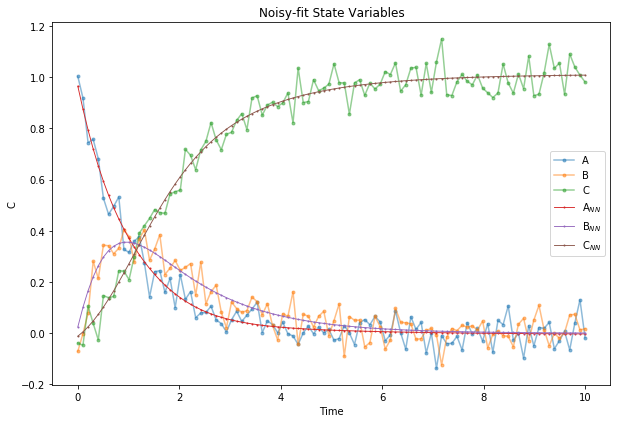

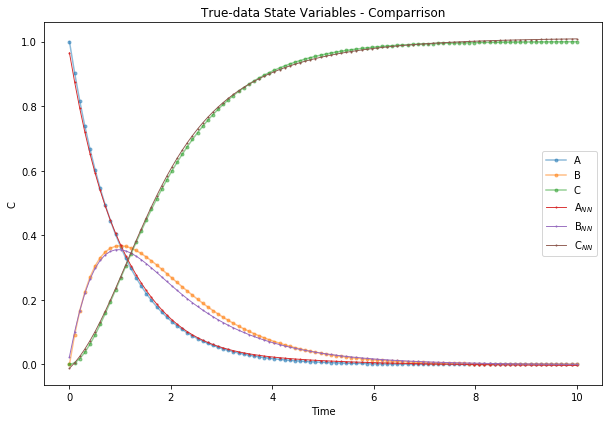

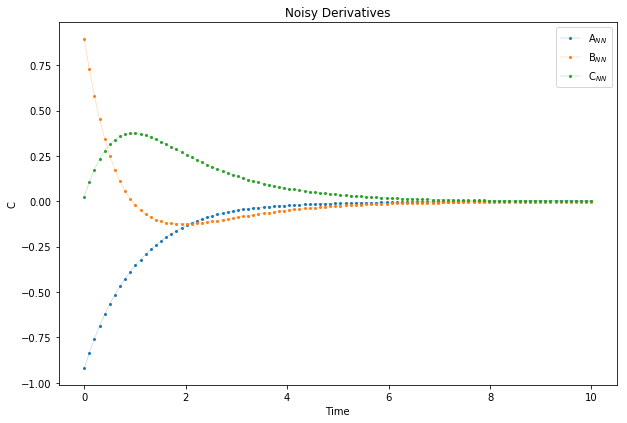

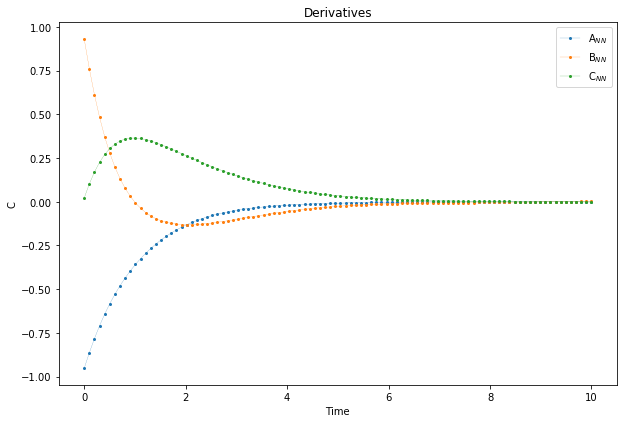

In [33]:
plt.figure(figsize=[10,10*2./3])
lines = plt.plot(t, data_inv_noisy[0],'-o',alpha=0.5,ms=3)
lines += plt.plot(t,batched_state(nn_params_inv_noisy, t),'.-',lw=0.9,ms=2)
plt.legend(iter(lines), ['A', 'B', 'C','A$_{NN}$','B$_{NN}$','C$_{NN}$'])
plt.title('Noisy-fit State Variables')
plt.xlabel('Time')
plt.ylabel('C');
plt.figure(figsize=[10,10*2./3])
lines = plt.plot(t, x0,'-o',alpha=0.5,ms=3)
lines += plt.plot(t,batched_state(nn_params_inv_noisy, t),'.-',lw=0.9,ms=2)
plt.legend(iter(lines), ['A', 'B', 'C','A$_{NN}$','B$_{NN}$','C$_{NN}$'])
plt.title('True-data State Variables - Comparrison')
plt.xlabel('Time')
plt.ylabel('C');
plt.figure(figsize=[10,10*2./3])
plt.plot(t,batched_model([batched_state(nn_params_inv_noisy,t),t],model_params_noisy),'-o',lw=0.2,ms=2)
plt.legend(['A$_{NN}$','B$_{NN}$','C$_{NN}$'])
plt.title('Noisy Derivatives')
plt.xlabel('Time')
plt.ylabel('C');
plt.figure(figsize=[10,10*2./3])
plt.plot(t,batched_model([batched_state(nn_params_inv,t),t],model_params_inv),'-o',lw=0.2,ms=2)
plt.legend(['A$_{NN}$','B$_{NN}$','C$_{NN}$'])
plt.title('Derivatives')
plt.xlabel('Time')
plt.ylabel('C');

print('True parameters: {}'.format(['{:.5f}'.format(float(_)) for _ in model_params0[0]]))
print('Regressed parameters: {}'.format(['{:.5f}'.format(float(_)) for _ in model_params_noisy[0]]))